In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

In [2]:
con =sqlite3.connect("E:\\1014\\NFL_Analysis\\nfl_db_2023.db")

sql_command = """
        SELECT A.time,A.gameId,A.playId,A.nflId,x as x_act, y as y_act ,s,yardsToGo,playDirection,team,possessionTeam 
        FROM
        tracking_data A
        inner JOIN
        (
            select gameId, playId, min(frameId) as start_frame,max(frameId) as end_frame from tracking_data 
                where event in ('ball_snap','autoevent_ballsnap','fumble', 'handoff', 'lateral','autoevent_passforward', 'pass_forward','qb_sack', 'qb_strip_sack', 'run') 
                group by gameId, playId
        )B
        on A.gameId=B.gameId
        and A.playID=B.playId
        and A.frameId >=start_frame
        and A.frameId <= end_frame
        inner JOIN
        play_data C
        on A.gameId=C.gameId
        and A.playId=C.playId
        where nflId not NULL


    """
td=pd.read_sql_query(sql_command,con)
con.close()

In [3]:
con =sqlite3.connect("E:\\1014\\NFL_Analysis\\nfl_db_2023.db")

sql_command = """
        select gameId,playId, --x as ball_x, y as ball_y
        first_value(x) over (partition by gameId,playId order by frameId ) as ball_x,
        first_value(y) over (partition by gameId,playId order by frameId) as ball_y
        from tracking_data
        where event in ('ball_snap','autoevent_ballsnap')
        and nflId is null
        group by gameId,playId


    """
ball_dist=pd.read_sql_query(sql_command,con)
con.close()

In [4]:
df=td.merge(ball_dist,on=['gameId','playId'])
df['action_flag']= np.where(df['team']==df['possessionTeam'],'Attack','Defense')

# resetting the origin to the coordinated of the ball at the biginning of the play, making the changes to the players coordinate

df['x']= df['ball_x']-df['x_act']
df['y']= df['ball_y']-df['y_act']

# playDirection: Direction that the offense is moving (left or right); we are going to set the offense is always moving to the right

df['x']= np.where(df['playDirection']=='left',-df['x'],df['x'])
df['y']= np.where(df['playDirection']=='left',-df['y'],df['y'])

df['dist_ball']= np.sqrt((df['x_act']-df['ball_x'])**2+(df['y_act']-df['ball_y'])**2)

In [5]:
max(df.x),min(df.x),max(df.y),min(df.y)

(22.32, -57.63999999999999, 44.54, -46.32)

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.shape

(6145106, 17)

In [8]:
for col in df.columns.tolist():
    na_prc= df[col].isnull().sum()/len(df[col])
    print(col, str(na_prc))

time 0.0
gameId 0.0
playId 0.0
nflId 0.0
x_act 0.0
y_act 0.0
s 0.0
yardsToGo 0.0
playDirection 0.0
team 0.0
possessionTeam 0.0
ball_x 0.0
ball_y 0.0
action_flag 0.0
x 0.0
y 0.0
dist_ball 0.0


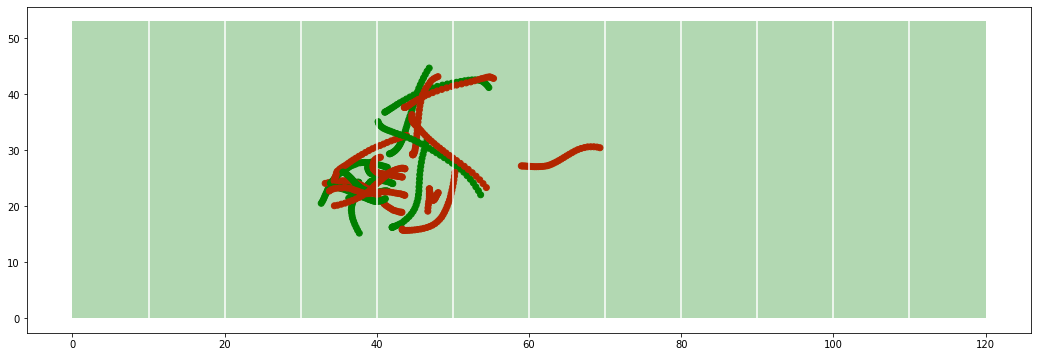

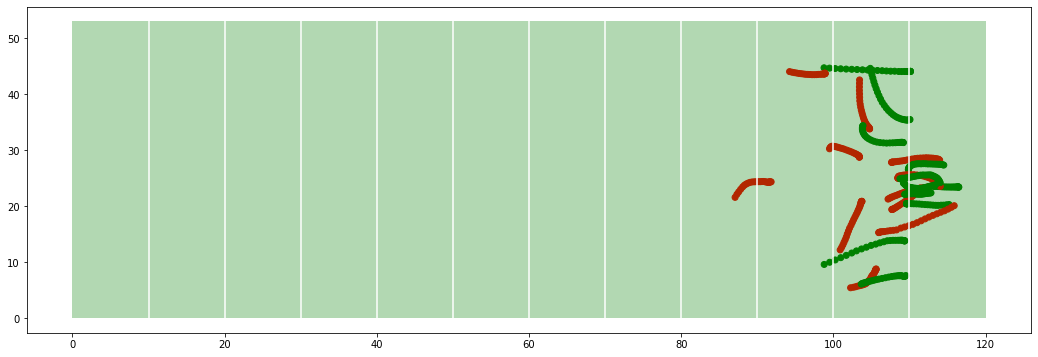

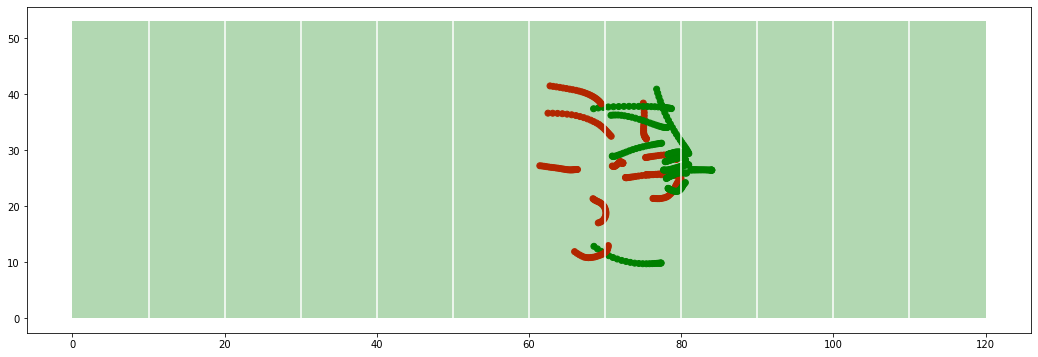

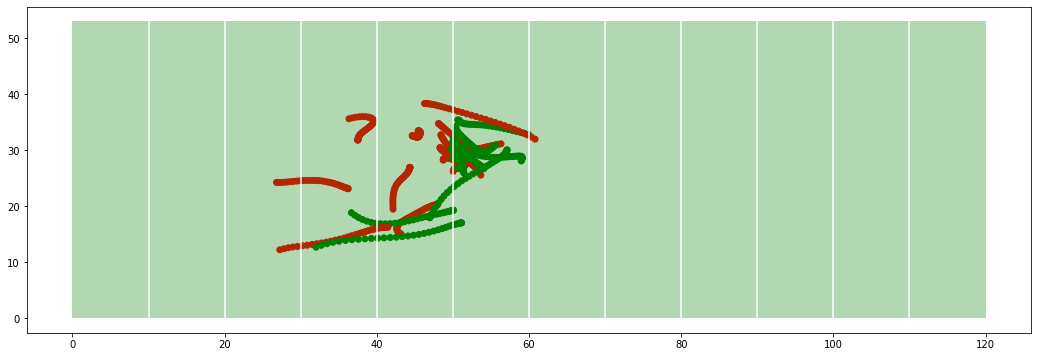

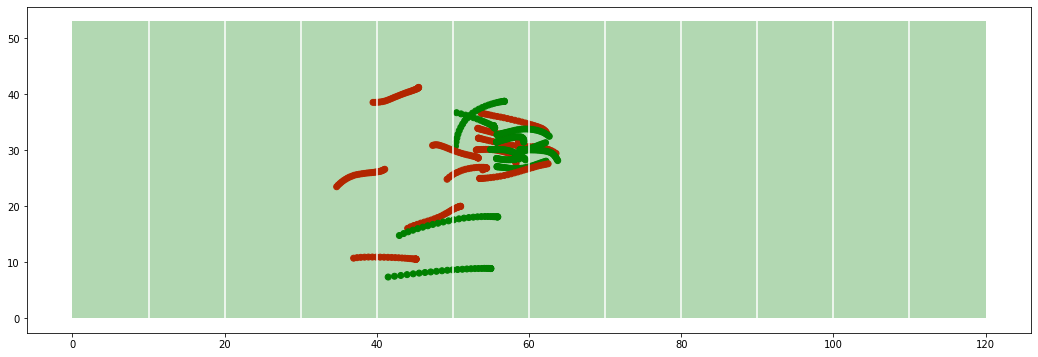

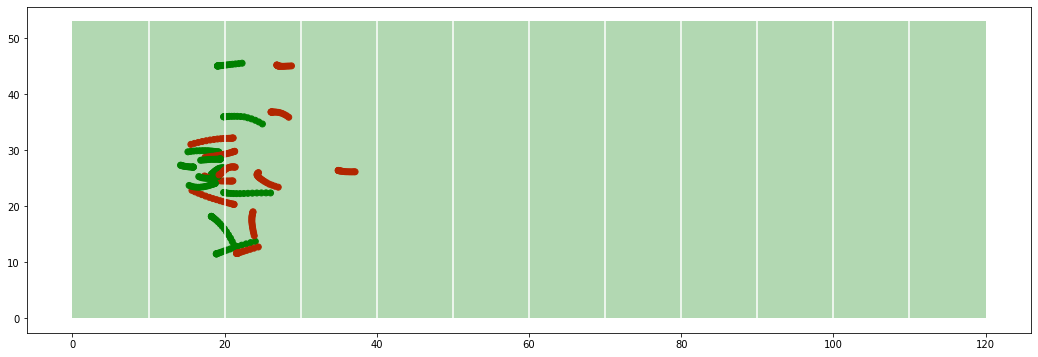

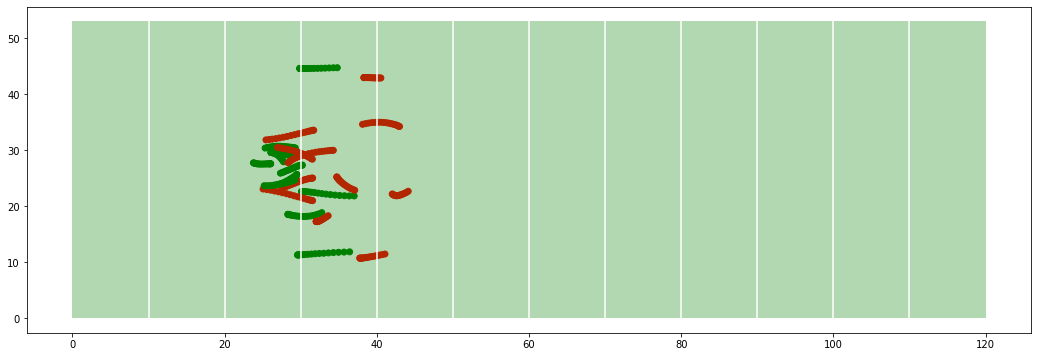

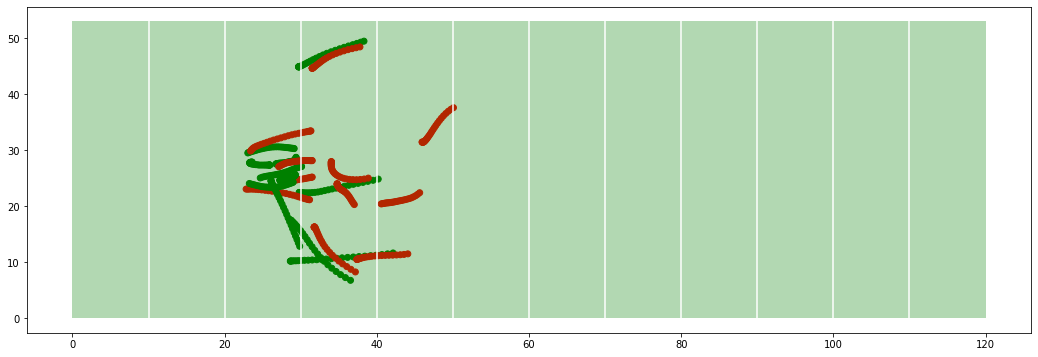

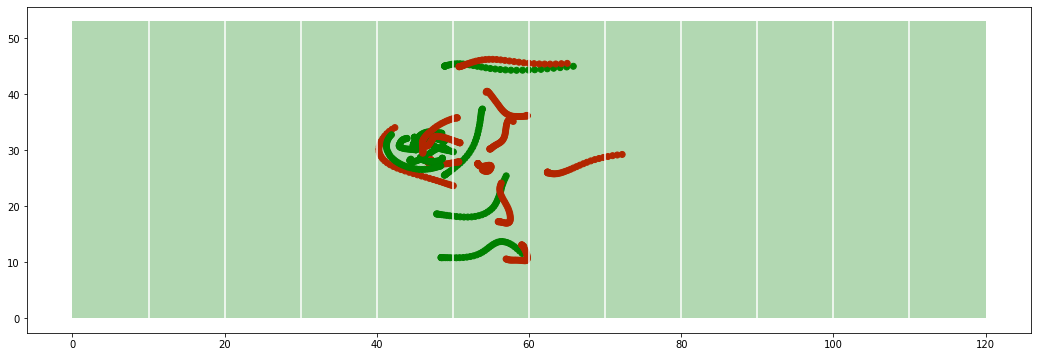

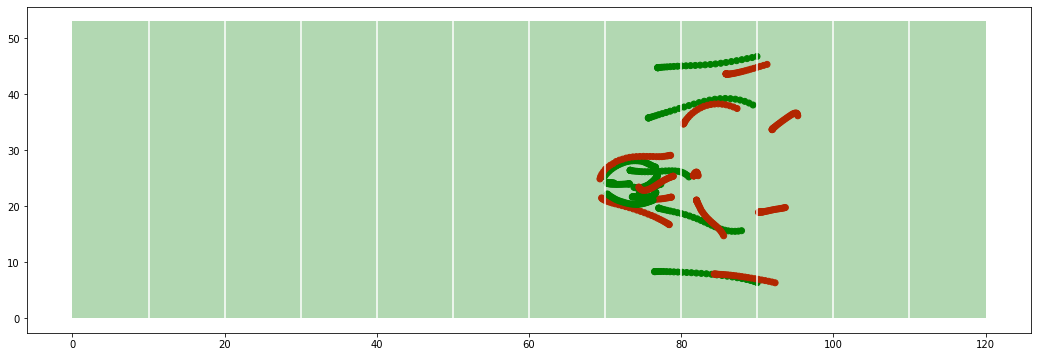

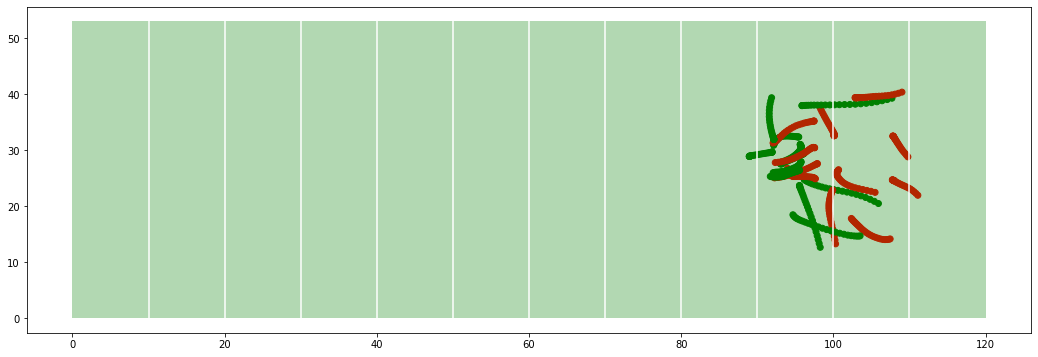

In [9]:
playId= [97,  137,  187,  282,  349,  410,  434,  456,  480,  509,  559]
colors = {'Attack':'green', 'Defense':'red', 'Ball':'black'}
for play in playId:
    
    fig, ax = plt.subplots(figsize=(18, 6))
    
    ax.scatter(df[(df.gameId==2021090900)&(df.playId==play)].x_act,df[(df.gameId==2021090900)&(df.playId==play)].y_act,alpha=1,c=df[(df.gameId==2021090900)&(df.playId==play)].action_flag.map(colors))
    
    rect=mpatches.Rectangle((0,0),120,53, alpha=0.3,facecolor="green")
    
    fig.gca().add_patch(rect)
    
    yards=[10,20,30,40,50,60,70,80,90,100,110]
    for x in yards:
        plt.axvline(x=x,c='white')
    

In [10]:
# Distance from the ball is taken into account for ordering the players

player_order = df[['time','gameId','playId','nflId','action_flag','y','dist_ball']]
player_order['dist_ball']= np.where(player_order['y']<=26.5,-1*player_order['dist_ball'],player_order['dist_ball'])
player_order.sort_values(by=['time','gameId','playId','nflId'],inplace=True)
player_order=player_order.groupby(['gameId','playId','nflId','action_flag'],as_index=False).aggregate({'time':'first','dist_ball':'first','y':'first'})
player_order['order']=player_order.groupby(['time','gameId','playId','action_flag'])['dist_ball'].rank('first').apply(int)
player_order['order']=player_order['order'].apply(str).str.zfill(2)
player_order.head()

C:\Users\Anton\anaconda3\envs\CPU\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Anton\anaconda3\envs\CPU\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,gameId,playId,nflId,action_flag,time,dist_ball,y,order
0,2021090900,97,25511,Attack,2021-09-10T00:26:31.600,-3.934717,-0.34,06
1,2021090900,97,35481,Attack,2021-09-10T00:26:31.600,-5.420747,-5.42,04
2,2021090900,97,35634,Attack,2021-09-10T00:26:31.600,-12.860517,-12.85,01
3,2021090900,97,39985,Attack,2021-09-10T00:26:31.600,-4.336196,1.65,05
4,2021090900,97,40151,Attack,2021-09-10T00:26:31.600,-0.549181,-0.10,11


In [11]:
inputdata=df.merge(player_order[['gameId','playId','nflId','action_flag','time','order']],on=['gameId','playId','nflId','action_flag','time'], how='left')

inputdata.sort_values(by=['gameId','playId','nflId','action_flag'],inplace=True)

inputdata['order'].ffill(inplace=True)
inputdata.sort_values(by=['time','gameId','playId','nflId','action_flag'],inplace=True)
inputdata.head(20)

,time,gameId,playId,nflId,x_act,y_act,s,yardsToGo,playDirection,team,possessionTeam,ball_x,ball_y,action_flag,x,y,dist_ball,order
0,2021-09-10T00:26:31.600,2021090900,97,25511,37.64,24.26,0.35,2.0,right,TB,TB,41.56,23.92,Attack,3.92,-0.34,3.934717,06
35,2021-09-10T00:26:31.600,2021090900,97,35481,41.65,29.34,1.20,2.0,right,TB,TB,41.56,23.92,Attack,-0.09,-5.42,5.420747,04
70,2021-09-10T00:26:31.600,2021090900,97,35634,41.04,36.77,0.48,2.0,right,TB,TB,41.56,23.92,Attack,0.52,-12.85,12.860517,01
105,2021-09-10T00:26:31.600,2021090900,97,39985,37.55,22.27,0.04,2.0,right,TB,TB,41.56,23.92,Attack,4.01,1.65,4.336196,05
140,2021-09-10T00:26:31.600,2021090900,97,40151,42.10,24.02,0.51,2.0,right,TB,TB,41.56,23.92,Attack,-0.54,-0.10,0.549181,11
175,2021-09-10T00:26:31.600,2021090900,97,41233,42.01,16.20,0.00,2.0,right,TB,TB,41.56,23.92,Attack,-0.45,7.72,7.733104,03
210,2021-09-10T00:26:31.600,2021090900,97,41263,43.30,18.89,0.96,2.0,right,DAL,TB,41.56,23.92,Defense,-1.74,5.03,5.322452,08
245,2021-09-10T00:26:31.600,2021090900,97,42377,41.38,26.92,0.85,2.0,right,TB,TB,41.56,23.92,Attack,0.18,-3.00,3.005395,07
280,2021-09-10T00:26:31.600,2021090900,97,42403,43.90,32.63,0.37,2.0,right,DAL,TB,41.56,23.92,Defense,-2.34,-8.71,9.018852,04
315,2021-09-10T00:26:31.600,2021090900,97,42404,41.93,25.65,0.00,2.0,right,TB,TB,41.56,23.92,Attack,-0.37,-1.73,1.769124,09


In [12]:
#dist_ball calculated in the above table was the distance at the biginning of the play. Now we are bringing the live cordinates 
#of the ball so that the distnce from the ball to each player for each frame can be included as an input attribute


con =sqlite3.connect("E:\\1014\\NFL_Analysis\\nfl_db_2023.db")

sql_command = """
        select time,gameId,playId,x as ball_frame_x,
        y as ball_frame_y
        from tracking_data
        where nflId is null
        group by time,gameId,playId 


    """
ball_frame_dist=pd.read_sql_query(sql_command,con)
con.close()


In [13]:
inputdata=inputdata.merge(ball_frame_dist,on=['time','gameId','playId'])
inputdata['dbf']= np.sqrt((inputdata['x_act']-inputdata['ball_frame_x'])**2+(inputdata['y_act']-inputdata['ball_frame_y'])**2)


In [14]:
max(inputdata['x']), min(inputdata['x'])

(22.32, -57.63999999999999)

In [15]:
max(inputdata['y']), min(inputdata['y'])

(44.54, -46.32)

In [16]:
max(inputdata['s']), min(inputdata['s'])

(10.81, 0.0)

In [17]:
max(inputdata['yardsToGo']), min(inputdata['yardsToGo'])

(39.0, 0.0)

In [18]:
max(inputdata['dbf']), min(inputdata['dbf'])

(73.42938172148803, 0.0)

In [19]:
inputdata= inputdata[(inputdata['x_act']>=0)&(inputdata['x_act']<=120)&(inputdata['y_act']>=0)&(inputdata['y_act']<=54)]
inputdata.head()

,time,gameId,playId,nflId,x_act,y_act,s,yardsToGo,playDirection,team,...,ball_x,ball_y,action_flag,x,y,dist_ball,order,ball_frame_x,ball_frame_y,dbf
0,2021-09-10T00:26:31.600,2021090900,97,25511,37.64,24.26,0.35,2.0,right,TB,...,41.56,23.92,Attack,3.92,-0.34,3.934717,06,41.56,23.92,3.934717
1,2021-09-10T00:26:31.600,2021090900,97,35481,41.65,29.34,1.20,2.0,right,TB,...,41.56,23.92,Attack,-0.09,-5.42,5.420747,04,41.56,23.92,5.420747
2,2021-09-10T00:26:31.600,2021090900,97,35634,41.04,36.77,0.48,2.0,right,TB,...,41.56,23.92,Attack,0.52,-12.85,12.860517,01,41.56,23.92,12.860517
3,2021-09-10T00:26:31.600,2021090900,97,39985,37.55,22.27,0.04,2.0,right,TB,...,41.56,23.92,Attack,4.01,1.65,4.336196,05,41.56,23.92,4.336196
4,2021-09-10T00:26:31.600,2021090900,97,40151,42.10,24.02,0.51,2.0,right,TB,...,41.56,23.92,Attack,-0.54,-0.10,0.549181,11,41.56,23.92,0.549181


In [20]:
#(df-df.min())/(df.max()-df.min())

inputdata['x']=(inputdata.x-min(inputdata.x))/(max(inputdata.x)-min(inputdata.x))
inputdata['y']=(inputdata.y-min(inputdata.y))/(max(inputdata.y)-min(inputdata.y))
inputdata['s']=inputdata.s/11
inputdata['yd']=inputdata.yardsToGo/40
inputdata['dbf']=inputdata.dbf/130 # assuming the maximum would be the diagonal distnce of the entire court



inputdata= inputdata.pivot_table(index=['time','gameId','playId'],columns=['action_flag','order'],values=['x','y','s','yd','dbf'],aggfunc='first')
inputdata.columns = ['_'.join(col) for col in inputdata.columns.values]
inputdata=inputdata.reset_index()
inputdata.sort_values(by=['time','gameId','playId'],inplace=True)
inputdata.dropna(axis=1, how='all',inplace=True)
inputdata.head()



,time,gameId,playId,dbf_Attack_01,dbf_Attack_02,dbf_Attack_03,dbf_Attack_04,dbf_Attack_05,dbf_Attack_06,dbf_Attack_07,...,yd_Defense_02,yd_Defense_03,yd_Defense_04,yd_Defense_05,yd_Defense_06,yd_Defense_07,yd_Defense_08,yd_Defense_09,yd_Defense_10,yd_Defense_11
0,2021-09-10T00:26:31.600,2021090900,97,0.098927,0.086595,0.059485,0.041698,0.033355,0.030267,0.023118,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
1,2021-09-10T00:26:31.700,2021090900,97,0.099077,0.083871,0.059909,0.042019,0.029560,0.027112,0.023210,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
2,2021-09-10T00:26:31.800,2021090900,97,0.099687,0.081588,0.060322,0.043013,0.026974,0.025030,0.023770,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
3,2021-09-10T00:26:31.900,2021090900,97,0.100734,0.079558,0.061093,0.045031,0.023958,0.022328,0.024698,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
4,2021-09-10T00:26:32.000,2021090900,97,0.102427,0.078000,0.062038,0.047847,0.020554,0.019480,0.025782,...,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


In [21]:
for col in inputdata.columns.tolist():
    val_col=[]
    na_prc= inputdata[col].isnull().sum()/len(inputdata[col])
    print(col, str(na_prc))

    

time 0.0
gameId 0.0
playId 0.0
dbf_Attack_01 0.0003257877081371745
dbf_Attack_02 0.0003222076234323704
dbf_Attack_03 3.9380931752845275e-05
dbf_Attack_04 0.00014678347289696873
dbf_Attack_05 0.00026492626815550455
dbf_Attack_06 0.0
dbf_Attack_07 1.0740254114412347e-05
dbf_Attack_08 0.0
dbf_Attack_09 0.0
dbf_Attack_10 1.0740254114412347e-05
dbf_Attack_11 0.0
dbf_Defense_01 0.0
dbf_Defense_02 2.8640677638432926e-05
dbf_Defense_03 0.0
dbf_Defense_04 1.7900423524020577e-05
dbf_Defense_05 1.4320338819216463e-05
dbf_Defense_06 2.8640677638432926e-05
dbf_Defense_07 2.506059293362881e-05
dbf_Defense_08 1.4320338819216463e-05
dbf_Defense_09 0.0
dbf_Defense_10 0.0
dbf_Defense_11 0.0
s_Attack_01 0.0003257877081371745
s_Attack_02 0.0003222076234323704
s_Attack_03 3.9380931752845275e-05
s_Attack_04 0.00014678347289696873
s_Attack_05 0.00026492626815550455
s_Attack_06 0.0
s_Attack_07 1.0740254114412347e-05
s_Attack_08 0.0
s_Attack_09 0.0
s_Attack_10 1.0740254114412347e-05
s_Attack_11 0.0
s_Defense_0

In [ ]:
inputdata.to_csv('inputdata.csv')

In [2]:
inputdata=pd.read_csv('inputdata.csv')

In [22]:
attack_col=['x_Attack_01','y_Attack_01','s_Attack_01','dbf_Attack_01',
            'x_Attack_02','y_Attack_02','s_Attack_02','dbf_Attack_02',
            'x_Attack_03','y_Attack_03','s_Attack_03','dbf_Attack_03',
            'x_Attack_04','y_Attack_04','s_Attack_04','dbf_Attack_04',
            'x_Attack_05','y_Attack_05','s_Attack_05','dbf_Attack_05',
            'x_Attack_06','y_Attack_06','s_Attack_06','dbf_Attack_06', 
            'x_Attack_07','y_Attack_07','s_Attack_07','dbf_Attack_07',
            'x_Attack_08','y_Attack_08','s_Attack_08','dbf_Attack_08',
            'x_Attack_09','y_Attack_09','s_Attack_09','dbf_Attack_09',
            'x_Attack_10','y_Attack_10','s_Attack_10','dbf_Attack_10',
            'x_Attack_11','y_Attack_11','s_Attack_11','dbf_Attack_11'        
           
           ]

defense_col=['x_Defense_01','y_Defense_01','s_Defense_01','dbf_Defense_01',
             'x_Defense_02','y_Defense_02','s_Defense_02','dbf_Defense_02',
             'x_Defense_03','y_Defense_03','s_Defense_03','dbf_Defense_03',
             'x_Defense_04','y_Defense_04','s_Defense_04','dbf_Defense_04',
             'x_Defense_05','y_Defense_05','s_Defense_05','dbf_Defense_05',
             'x_Defense_06','y_Defense_06','s_Defense_06','dbf_Defense_06', 
             'x_Defense_07','y_Defense_07','s_Defense_07','dbf_Defense_07',
             'x_Defense_08','y_Defense_08','s_Defense_08','dbf_Defense_08',
             'x_Defense_09','y_Defense_09','s_Defense_09','dbf_Defense_09',
             'x_Defense_10','y_Defense_10','s_Defense_10','dbf_Defense_10',
             'x_Defense_11','y_Defense_11','s_Defense_11','dbf_Defense_11'
            ]

In [23]:
inputdata[attack_col+defense_col].dropna(axis=0).shape

(279015, 88)

In [24]:
inputdata= inputdata[['time','gameId','playId']+attack_col+defense_col]
inputdata.dropna(axis=0,inplace=True)

In [25]:
def data_proc(data,seq_ln,forecast_ln):
    X=[]
    Y=[]
    
    start=0
    end= seq_ln
    forecast_end= seq_ln+forecast_ln    
    
    for n in range(data.shape[0]- (seq_ln+forecast_ln)):
        
        values=data.values
        X.append(values[start:end].tolist())
        Y.append(values[end:forecast_end].tolist())
        
        start+=1
        end+=1
        forecast_end+=1
        
    #X= np.reshape(X,(data.shape[0],seq_ln,1))
    #Y= np.reshape(Y,(data.shape[0],forecast_ln,1))  
    return X,Y

In [54]:
in_len=2
out_len=30
offense_past=[]
offense_next =[]

for gameid in inputdata.gameId.unique().tolist():
    for playid in inputdata.playId.unique().tolist():
        
        offense_sq=inputdata[(inputdata['gameId']==gameid)&(inputdata['playId']==playid)][attack_col]
        x,y= data_proc(offense_sq,in_len,out_len)
        
        offense_past.append(x)
        offense_next.append(y)



#defense_sq= inputdata[defense_col]
#defense_past30, defense_next10= data_proc(defense_sq,30,10)

In [55]:
len(offense_past[0])

3

In [56]:

defense_past=[]
defense_next =[]

for gameid in inputdata.gameId.unique().tolist():
    for playid in inputdata.playId.unique().tolist():
        
        defense_sq=inputdata[(inputdata['gameId']==gameid)&(inputdata['playId']==playid)][defense_col]
        x,y= data_proc(defense_sq,in_len,out_len)
        defense_past.append(x)
        defense_next.append(y)



#defense_sq= inputdata[defense_col]
#defense_past30, defense_next10= data_proc(defense_sq,30,10)

In [57]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [58]:
offense_past= flatten(offense_past)
offense_next =flatten(offense_next)

defense_past= flatten(defense_past)
defense_next =flatten(defense_next)


In [59]:
offense_past= np.array(offense_past)
offense_next =np.array(offense_next)

defense_past= np.array(defense_past)
defense_next =np.array(defense_next)

In [60]:
offense_past.shape,defense_past.shape

((39423, 2, 44), (39423, 2, 44))

In [61]:
offense_defense_past =np.ones((offense_past.shape[0],offense_past.shape[1],offense_past.shape[2]+defense_past.shape[2]))
for c in range(offense_past.shape[0]):
    for t in range(offense_past.shape[1]):
        offense_defense_past[c][t]= np.append(offense_past[c][t],defense_past[c][t])
        
offense_defense_past.shape



(39423, 2, 88)

In [62]:
defence_target= np.ones((defense_next.shape[0],defense_next.shape[1],22)) #removing the speed and distance to ball value from the target data
a= pd.Series(np.arange(0,44,4)).append(pd.Series(np.arange(1,44,4))).tolist()
a.sort()

for c in range(defense_next.shape[0]):
    for t in range(defense_next.shape[1]):
        defence_target[c][t]= defense_next[c][t][a]
defence_target.shape

(39423, 30, 22)

In [63]:
from sklearn.model_selection import train_test_split


In [64]:
test_len= int(0.9*offense_defense_past.shape[0])
test_len

35480

In [65]:
x_train_val= offense_defense_past[:test_len]
x_test= offense_defense_past[test_len:]

y_train_val = defence_target[:test_len]
y_test= defence_target[test_len:]


In [66]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val,y_train_val, random_state=0, train_size = .8)


In [67]:
x_train.shape, x_test.shape,x_val.shape

((28384, 2, 88), (3943, 2, 88), (7096, 2, 88))

In [68]:
y_train.shape, y_test.shape,y_val.shape

((28384, 30, 22), (3943, 30, 22), (7096, 30, 22))

In [69]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [70]:
epochs = 50
batch_size = 32
validation = 0.1
callback = EarlyStopping(monitor='loss', patience=3)

In [71]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(200, activation='relu', 
                    input_shape=(x_train.shape[1],x_train.shape[2])))
LSTM_model.add(RepeatVector(y_train.shape[1]))
LSTM_model.add(LSTM(200, activation='relu', return_sequences=True))
LSTM_model.add(TimeDistributed(Dense(100, activation='relu')))
LSTM_model.add(TimeDistributed(Dense(y_train.shape[2])))
LSTM_model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               231200    
                                                                 
 repeat_vector_1 (RepeatVect  (None, 30, 200)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 30, 200)           320800    
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 100)          20100     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 22)           2222      
 tributed)                                                       
                                                      

In [72]:
LSTM_history=LSTM_model.fit(x_train,y_train,batch_size=10,epochs=100,validation_data=(x_val,y_val),callbacks=[callback])


Epoch 1/100
2839/2839 [==============================] - 73s 25ms/step - loss: 0.0108 - val_loss: 0.0030
Epoch 2/100
2839/2839 [==============================] - 76s 27ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 3/100
2839/2839 [==============================] - 80s 28ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/100
2839/2839 [==============================] - 83s 29ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/100
2839/2839 [==============================] - 86s 30ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/100
2839/2839 [==============================] - 88s 31ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/100
2839/2839 [==============================] - 87s 31ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/100
2839/2839 [==============================] - 90s 32ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/100
2839/2839 [==============================] - 90s 32ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/100
2839/2839 [==============================]

2839/2839 [==============================] - 151s 53ms/step - loss: 4.8639e-04 - val_loss: 5.7183e-04
Epoch 75/100
2839/2839 [==============================] - 152s 54ms/step - loss: 4.8033e-04 - val_loss: 5.3827e-04
Epoch 76/100
2839/2839 [==============================] - 153s 54ms/step - loss: 4.7834e-04 - val_loss: 5.1229e-04
Epoch 77/100
2839/2839 [==============================] - 151s 53ms/step - loss: 4.7197e-04 - val_loss: 5.0438e-04
Epoch 78/100
2839/2839 [==============================] - 152s 53ms/step - loss: 4.6804e-04 - val_loss: 5.4878e-04
Epoch 79/100
2839/2839 [==============================] - 151s 53ms/step - loss: 4.6364e-04 - val_loss: 5.2790e-04
Epoch 80/100
2839/2839 [==============================] - 149s 52ms/step - loss: 4.5949e-04 - val_loss: 4.8346e-04
Epoch 81/100
2839/2839 [==============================] - 151s 53ms/step - loss: 4.5603e-04 - val_loss: 4.9635e-04
Epoch 82/100
2839/2839 [==============================] - 151s 53ms/step - loss: 4.5047e-04 -

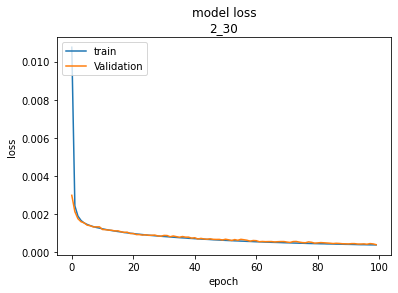

In [73]:
# summarize history for loss
plt.plot(LSTM_history.history['loss'])
plt.plot(LSTM_history.history['val_loss'])
plt.title('model loss\n'+str(in_len)+'_'+str(out_len))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [74]:
predictions=LSTM_model.predict(x_test)

124/124 [==============================] - 2s 14ms/step


In [75]:
predictions.shape

(3943, 30, 22)

In [76]:
np.corrcoef((flatten(flatten(y_train))),flatten(flatten(LSTM_model.predict(x_train))))[0,1]**2

887/887 [==============================] - 14s 16ms/step


0.9783749607714434

In [77]:
np.corrcoef((flatten(flatten(y_test))),flatten(flatten(predictions)))[0,1]**2

0.9013742890337167

In [78]:
from sklearn.metrics import r2_score 
print("R-Square value from train: ",r2_score((flatten(flatten(y_train))),flatten(flatten(LSTM_model.predict(x_train)))))
print("max deviation train: ",max(np.subtract((flatten(flatten(y_train))),flatten(flatten(LSTM_model.predict(x_train))))))

print("R-Square value from val: ",r2_score((flatten(flatten(y_val))),flatten(flatten(LSTM_model.predict(x_val)))))
print("max deviation val: ",max(np.subtract((flatten(flatten(y_val))),flatten(flatten(LSTM_model.predict(x_val))))))

print("R-Square value from test: ",r2_score((flatten(flatten(y_test))),flatten(flatten(LSTM_model.predict(x_test)))))
print("max deviation test: ",max(np.subtract((flatten(flatten(y_test))),flatten(flatten(LSTM_model.predict(x_test))))))


887/887 [==============================] - 14s 16ms/step
R-Square value from train:  0.9782397133089553
887/887 [==============================] - 15s 16ms/step
max deviation train:  0.2631794739031923
222/222 [==============================] - 4s 16ms/step
R-Square value from val:  0.9755373755109801
222/222 [==============================] - 4s 16ms/step
max deviation val:  0.25737544350053976
124/124 [==============================] - 2s 16ms/step
R-Square value from test:  0.900670748297303
124/124 [==============================] - 2s 16ms/step
max deviation test:  0.36752173242893305


In [79]:
LSTM_model.save('E:/1014/NFL_Analysis/Simulation_models/New_model/model_'+str(in_len)+'_'+str(out_len))

INFO:tensorflow:Assets written to: E:/1014/NFL_Analysis/Simulation_models/New_model/model_2_30\assets


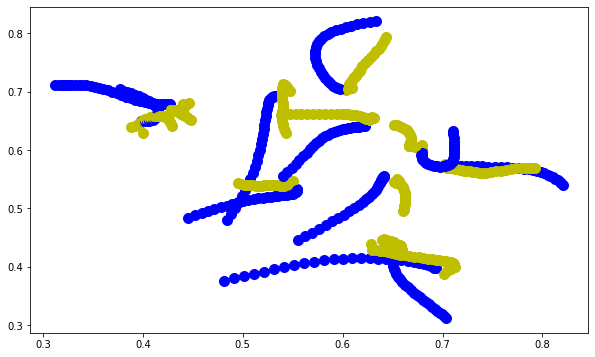

In [80]:
n=1

fig, ax = plt.subplots(figsize=(10, 6))

for t in range(30):
    for player in range(11):
        ax.scatter(predictions[n][t][player],predictions[n][t][player+1],c='y',s=100)
        ax.scatter(y_test[n][t][player],y_test[n][t][player+1],c='b',s=100)
        
  

In [ ]:
plt.scatter((flatten(flatten(y_test))),flatten(flatten(model_enc_dec_cnn.predict(x_test))))

In [ ]:
plt.scatter(flatten(y_test[:,4,:]),flatten(predictions[:,4,:]))

In [112]:
import seaborn as sns


<AxesSubplot:ylabel='Count'>

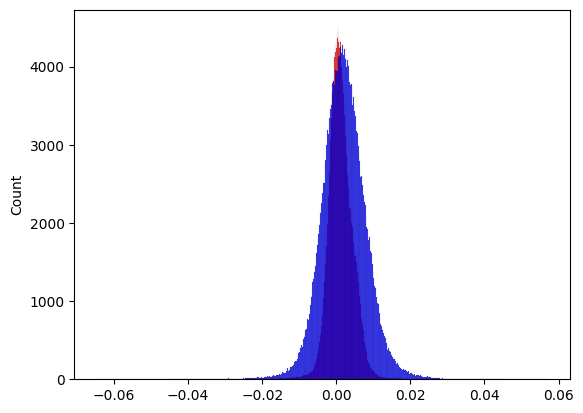

In [113]:
error= np.subtract(flatten(y_test[:,0,:]),flatten(predictions[:,0,:]))
sns.histplot(error,color='red')
sns.histplot(np.subtract(flatten(y_test[:,4,:]),flatten(predictions[:,4,:])),color='blue')

In [116]:
y_test.shape

(10929, 10, 22)

In [117]:
error_step1= np.subtract(flatten(y_test[:,0,:]),flatten(predictions[:,0,:]))
error_step2= np.subtract(flatten(y_test[:,2,:]),flatten(predictions[:,2,:]))
error_step3= np.subtract(flatten(y_test[:,4,:]),flatten(predictions[:,4,:]))
error_step4= np.subtract(flatten(y_test[:,6,:]),flatten(predictions[:,6,:]))
error_step5= np.subtract(flatten(y_test[:,8,:]),flatten(predictions[:,8,:]))


C:\study_tools\envs\DL\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
C:\study_tools\envs\DL\lib\site-packages\ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
C:\study_tools\envs\DL\lib\site

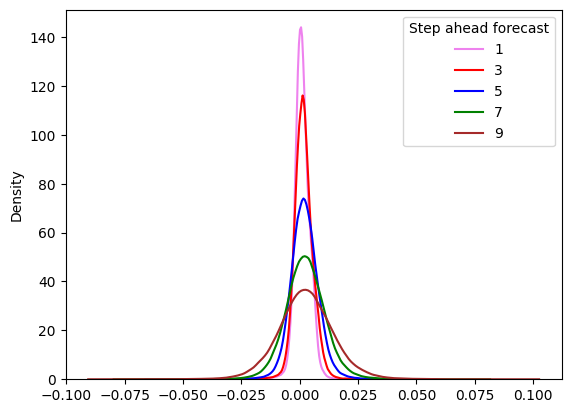

In [119]:

sns.distplot(error_step1,color='violet',hist=False,label='1')
sns.distplot(error_step2,color='red',hist=False,label='3')
sns.distplot(error_step3,color='blue',hist=False,label='5')
sns.distplot(error_step4,color='green',hist=False,label='7')
sns.distplot(error_step5,color='brown',hist=False,label='9')

plt.legend(title="Step ahead forecast")
plt.show()

In [ ]:
plt.bar(
    [np.square(error_step1).mean()*10,
     np.square(error_step2).mean()*10,
     np.square(error_step3).mean()*10,
     np.square(error_step4).mean()*10,
     np.square(error_step5).mean()*10])

In [ ]:
df=td.merge(ball_dist,on=['gameId','playId'])
df['action_flag']= np.where(df['team']==df['possessionTeam'],'Attack','Defense')
# playDirection: Direction that the offense is moving (left or right); we are going to set the offense is always moving to the right

df['x']= np.where(df['playDirection']=='left',120-df['x_act'],df['x_act'])
df['y']= np.where(df['playDirection']=='left',52-df['y_act'],df['y_act'])




df['dist_ball']= np.sqrt((df['x_act']-df['ball_x'])**2+(df['y_act']-df['ball_y'])**2)

player_order = df[['time','gameId','playId','nflId','action_flag','y','dist_ball']]
player_order['dist_ball']= np.where(player_order['y']<=26.5,-1*player_order['dist_ball'],player_order['dist_ball'])
player_order.sort_values(by=['time','gameId','playId','nflId'],inplace=True)
player_order=player_order.groupby(['gameId','playId','nflId','action_flag'],as_index=False).aggregate({'time':'first','dist_ball':'first','y':'first'})
player_order['order']=player_order.groupby(['time','gameId','playId','action_flag'])['dist_ball'].rank('first').apply(int)
player_order['order']=player_order['order'].apply(str).str.zfill(2)


rawdata=df.merge(player_order[['gameId','playId','nflId','action_flag','time','order']],on=['gameId','playId','nflId','action_flag','time'], how='left')

rawdata.sort_values(by=['gameId','playId','nflId','action_flag'],inplace=True)

rawdata['order'].ffill(inplace=True)
rawdata.sort_values(by=['time','gameId','playId','nflId','action_flag'],inplace=True)
rawdata=rawdata.merge(ball_frame_dist,on=['time','gameId','playId'])

rawdata['ball_frame_x']= np.where(rawdata['playDirection']=='left',120-rawdata['ball_frame_x'],rawdata['ball_frame_x'])
rawdata['ball_frame_y']= np.where(rawdata['playDirection']=='left',52-rawdata['ball_frame_y'],rawdata['ball_frame_y'])

rawdata['dbf']= np.sqrt((rawdata['x_act']-rawdata['ball_frame_x'])**2+(rawdata['y_act']-rawdata['ball_frame_y'])**2)
rawdata['yd']=rawdata.yardsToGo
rawdata= rawdata[(rawdata['x_act']>=0)&(rawdata['x_act']<=120)&(rawdata['y_act']>=0)&(rawdata['y_act']<=54)]

ballcoordiantes= rawdata.groupby(['time','gameId','playId'],as_index=False).aggregate({'ball_frame_x':'first','ball_frame_y':'first'})
ballcoordiantes.dropna(axis=1, how='all',inplace=True)
ballcoordinates_col=['ball_frame_x','ball_frame_y']


rawdata= rawdata.pivot_table(index=['time','gameId','playId'],columns=['action_flag','order'],values=['x','y','s','yd','dbf'],aggfunc='first')
rawdata.columns = ['_'.join(col) for col in rawdata.columns.values]
rawdata=rawdata.reset_index()
rawdata.sort_values(by=['time','gameId','playId'],inplace=True)
rawdata.dropna(axis=1, how='all',inplace=True)



rawdata= rawdata[['time','gameId','playId']+attack_col+defense_col]
rawdata.dropna(axis=0,inplace=True)

ballcoordiantes=pd.merge(ballcoordiantes,rawdata[['time','gameId','playId']],on=['time','gameId','playId'],how='inner')
ballcoordiantes.dropna(axis=0,inplace=True)

rawdata.shape,ballcoordiantes.shape

in_len=25
out_len=25
raw_offense_past=[]
raw_offense_next =[]

for gameid in rawdata.gameId.unique().tolist():
    for playid in rawdata.playId.unique().tolist():
        
        offense_sq=rawdata[(rawdata['gameId']==gameid)&(rawdata['playId']==playid)][attack_col]
        x,y= data_proc(offense_sq,in_len,out_len)
        
        raw_offense_past.append(x)
        raw_offense_next.append(y)




raw_defense_past=[]
raw_defense_next =[]

for gameid in rawdata.gameId.unique().tolist():
    for playid in rawdata.playId.unique().tolist():
        
        defense_sq=rawdata[(rawdata['gameId']==gameid)&(rawdata['playId']==playid)][defense_col]
        x,y= data_proc(defense_sq,in_len,out_len)
        raw_defense_past.append(x)
        raw_defense_next.append(y)
        
        
ball_past=[]
ball_next =[]

for gameid in rawdata.gameId.unique().tolist():
    for playid in rawdata.playId.unique().tolist():
        
        ball_sq=ballcoordiantes[(ballcoordiantes['gameId']==gameid)&(ballcoordiantes['playId']==playid)][ballcoordinates_col]
        x,y= data_proc(ball_sq,in_len,out_len)
        
        ball_past.append(x)
        ball_next.append(y)        

raw_offense_past= flatten(raw_offense_past)
raw_offense_next =flatten(raw_offense_next)
raw_defense_past= flatten(raw_defense_past)
raw_defense_next =flatten(raw_defense_next)

raw_offense_past= np.array(raw_offense_past)
raw_offense_next =np.array(raw_offense_next)
raw_defense_past= np.array(raw_defense_past)
raw_defense_next =np.array(raw_defense_next)

ball_past= flatten(ball_past)
ball_next =flatten(ball_next)
ball_past= np.array(ball_past)
ball_next =np.array(ball_next)

raw_offense_next_cropped= np.ones((raw_offense_next.shape[0],raw_offense_next.shape[1],22)) #removing the speed and distance to ball value from the target data
a= pd.Series(np.arange(0,44,4)).append(pd.Series(np.arange(1,44,4))).tolist()
a.sort()

for c in range(raw_offense_next.shape[0]):
    for t in range(raw_offense_next.shape[1]):
        raw_offense_next_cropped[c][t]= raw_offense_next[c][t][a]
raw_offense_next_cropped.shape

raw_defense_next_cropped= np.ones((raw_defense_next.shape[0],raw_defense_next.shape[1],22)) #removing the speed and distance to ball value from the target data
a= pd.Series(np.arange(0,44,4)).append(pd.Series(np.arange(1,44,4))).tolist()
a.sort()

for c in range(raw_defense_next.shape[0]):
    for t in range(raw_defense_next.shape[1]):
        raw_defense_next_cropped[c][t]= raw_defense_next[c][t][a]
raw_defense_next_cropped.shape

defense_next_cropped= np.ones((defense_next.shape[0],defense_next.shape[1],22)) #removing the speed and distance to ball value from the target data
a= pd.Series(np.arange(0,44,4)).append(pd.Series(np.arange(1,44,4))).tolist()
a.sort()

for c in range(defense_next.shape[0]):
    for t in range(defense_next.shape[1]):
        defense_next_cropped[c][t]= defense_next[c][t][a]
defense_next_cropped.shape

ball_next.shape

In [ ]:
#Predicted_values= model_enc_dec_cnn.predict(offense_defense_past)

In [ ]:
Predicted_values= LSTM_model.predict(offense_defense_past)

In [ ]:
r_square_table=[]

for n in range(defence_target.shape[0]):
    r_square= np.corrcoef((flatten(defence_target[n])),flatten(Predicted_values[n]))[0,1]**2
    r_square_table.append([n,r_square])
    


In [ ]:
r_square_table=pd.DataFrame(r_square_table)
r_square_table.columns=["n","r_square"]

r_square_table.sort_values(by=["r_square"],ascending=False,inplace=True)

In [ ]:
#r_square_table[r_square_table['r_square']<=0.60].head()
r_square_table.tail()

In [ ]:
import matplotlib.patches as mpatches
from celluloid import Camera

In [ ]:
n=7643


%matplotlib notebook

#camera = Camera(plt.figure())
fig, ax = plt.subplots(figsize=(10, 6))
camera = Camera(fig)


yards=[10,20,30,40,50,60,70,80,90,100,110]


for t in range(25):
    [plt.axvline(_x, linewidth=1, color='w') for _x in yards]
    rect=mpatches.Rectangle((0,0),120,52, alpha=0.3,facecolor="green")
    fig.gca().add_patch(rect)
    
    for player in range(11):
        ax.scatter(raw_offense_next_cropped[n][t][player*2],raw_offense_next_cropped[n][t][(player*2)+1],c='r',s=100)
        ax.scatter(raw_defense_next_cropped[n][t][player*2],raw_defense_next_cropped[n][t][(player*2)+1],c='b',s=100)
        
        ## if t<5:
        ##     error_x= 1-(defense_next_cropped[n][t][player*2]/Predicted_values1[n][t][player*2])
        ##     error_y= 1-(defense_next_cropped[n][t][(player*2)+1]/Predicted_values1[n][t][(player*2)+1])
## 
        ## if 5<=t<10:
        ##     error_x= 1-(defense_next_cropped[n][t-5][player*2]/Predicted_values1[n][t-5][player*2])
        ##     error_y= 1-(defense_next_cropped[n][t-5][(player*2)+1]/Predicted_values1[n][t-5][(player*2)+1])
        ##     
        ## if 10<=t<15:
        ##     error_x= 1-(defense_next_cropped[n][t-10][player*2]/Predicted_values1[n][t-10][player*2])
        ##     error_y= 1-(defense_next_cropped[n][t-10][(player*2)+1]/Predicted_values1[n][t-10][(player*2)+1])
        ##     
        ## if 15<=t<20:
        ##     error_x= 1-(defense_next_cropped[n][t-15][player*2]/Predicted_values1[n][t-15][player*2])
        ##     error_y= 1-(defense_next_cropped[n][t-15][(player*2)+1]/Predicted_values1[n][t-15][(player*2)+1])
        ##     
        ## if 20<=t<25:
        ##     error_x= 1-(defense_next_cropped[n][t-20][player*2]/Predicted_values1[n][t-20][player*2])
        ##     error_y= 1-(defense_next_cropped[n][t-20][(player*2)+1]/Predicted_values1[n][t-20][(player*2)+1])
            
        error_x= 1-(defense_next_cropped[n][t][player*2]/Predicted_values[n][t][player*2])
        error_y= 1-(defense_next_cropped[n][t][(player*2)+1]/Predicted_values[n][t][(player*2)+1])

        gh_x= raw_defense_next_cropped[n][t][player*2]+(error_x*raw_defense_next_cropped[n][t][player*2])
        gh_y= raw_defense_next_cropped[n][t][(player*2)+1]+(error_y*raw_defense_next_cropped[n][t][(player*2)+1])
        
        ax.scatter(gh_x,gh_y,c='white',s=100,alpha=0.5)
        ax.scatter(ball_next[n][t][0],ball_next[n][t][1],c='y',s=50)
        
        
    camera.snap()
anim=camera.animate(interval = 200)
anim.save('LSTM_test_25_25.gif')        

In [ ]:
n=7643



#camera = Camera(plt.figure())
fig, ax = plt.subplots(figsize=(10, 6))



yards=[10,20,30,40,50,60,70,80,90,100,110]
[plt.axvline(_x, linewidth=1, color='w') for _x in yards]
rect=mpatches.Rectangle((0,0),120,52, alpha=0.3,facecolor="green")
fig.gca().add_patch(rect)

for t in range(25):

    
    for player in range(11):
        ax.scatter(raw_offense_next_cropped[n][t][player*2],raw_offense_next_cropped[n][t][(player*2)+1],c='r',s=100,alpha=0.01*t)
        ax.scatter(raw_defense_next_cropped[n][t][player*2],raw_defense_next_cropped[n][t][(player*2)+1],c='b',s=100,alpha=0.01*t)
        
        ## if t<5:
        ##     error_x= 1-(defense_next_cropped[n][t][player*2]/Predicted_values1[n][t][player*2])
        ##     error_y= 1-(defense_next_cropped[n][t][(player*2)+1]/Predicted_values1[n][t][(player*2)+1])
## 
        ## if 5<=t<10:
        ##     error_x= 1-(defense_next_cropped[n][t-5][player*2]/Predicted_values1[n][t-5][player*2])
        ##     error_y= 1-(defense_next_cropped[n][t-5][(player*2)+1]/Predicted_values1[n][t-5][(player*2)+1])
        ##     
        ## if 10<=t<15:
        ##     error_x= 1-(defense_next_cropped[n][t-10][player*2]/Predicted_values1[n][t-10][player*2])
        ##     error_y= 1-(defense_next_cropped[n][t-10][(player*2)+1]/Predicted_values1[n][t-10][(player*2)+1])
        ##     
        ## if 15<=t<20:
        ##     error_x= 1-(defense_next_cropped[n][t-15][player*2]/Predicted_values1[n][t-15][player*2])
        ##     error_y= 1-(defense_next_cropped[n][t-15][(player*2)+1]/Predicted_values1[n][t-15][(player*2)+1])
        ##     
        ## if 20<=t<25:
        ##     error_x= 1-(defense_next_cropped[n][t-20][player*2]/Predicted_values1[n][t-20][player*2])
        ##     error_y= 1-(defense_next_cropped[n][t-20][(player*2)+1]/Predicted_values1[n][t-20][(player*2)+1])
            
        error_x= 1-(defense_next_cropped[n][t][player*2]/Predicted_values[n][t][player*2])
        error_y= 1-(defense_next_cropped[n][t][(player*2)+1]/Predicted_values[n][t][(player*2)+1])

        gh_x= raw_defense_next_cropped[n][t][player*2]+(error_x*raw_defense_next_cropped[n][t][player*2])
        gh_y= raw_defense_next_cropped[n][t][(player*2)+1]+(error_y*raw_defense_next_cropped[n][t][(player*2)+1])
        
        ax.scatter(gh_x,gh_y,c='white',s=100,alpha=0.01*t)
        ax.scatter(ball_next[n][t][0],ball_next[n][t][1],c='y',s=50,alpha=0.01*t)
        
 

In [ ]:
y_test.shape

In [ ]:
## This is to plot some visualf for the confirmation report

In [ ]:
from tensorflow.keras.models import load_model
old_model = load_model('D:/1014/NFL_Analysis/Simulation_models/model_10_10')

In [ ]:
predictions_test=old_model.predict(x_test)

In [ ]:
error_step1= np.subtract(flatten(y_test[:,0,:]),flatten(predictions_test[:,0,:]))
error_step2= np.subtract(flatten(y_test[:,2,:]),flatten(predictions_test[:,2,:]))
error_step3= np.subtract(flatten(y_test[:,4,:]),flatten(predictions_test[:,4,:]))
error_step4= np.subtract(flatten(y_test[:,6,:]),flatten(predictions_test[:,6,:]))
error_step5= np.subtract(flatten(y_test[:,9,:]),flatten(predictions_test[:,9,:]))


In [ ]:

sns.distplot(error_step1,color='violet',hist=False,label='1')
sns.distplot(error_step2,color='red',hist=False,label='2')
sns.distplot(error_step3,color='blue',hist=False,label='3')
sns.distplot(error_step4,color='green',hist=False,label='4')
sns.distplot(error_step5,color='yellow',hist=False,label='1')

plt.legend()
plt.show()

In [ ]:
np.corrcoef((flatten(flatten(y_test))),flatten(flatten(predictions_test)))[0,1]**2

In [ ]:
offense_next.shape,defence_target.shape

In [ ]:
offense_defense_past
defence_target

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('D:/1014/NFL_Analysis/Simulation_models/model_10_5')

In [ ]:
Predicted_values= model.predict(offense_defense_past)

In [ ]:
r_square_table=[]

for n in range(x_train.shape[0]):
    r_square= np.corrcoef((flatten(defence_target[n])),flatten(Predicted_values[n]))[0,1]**2
    r_square_table.append([n,r_square])
    


In [ ]:
r_square_table=pd.DataFrame(r_square_table)
r_square_table.columns=["n","r_square"]

r_square_table.sort_values(by=["r_square"],ascending=False,inplace=True)

In [ ]:
r_square_table.head()

In [ ]:
offense_next_cropped= np.ones((offense_next.shape[0],offense_next.shape[1],22)) #removing the speed and distance to ball value from the target data
a= pd.Series(np.arange(0,44,4)).append(pd.Series(np.arange(1,44,4))).tolist()
a.sort()

for c in range(offense_next.shape[0]):
    for t in range(offense_next.shape[1]):
        offense_next_cropped[c][t]= offense_next[c][t][a]
offense_next_cropped.shape

In [ ]:
import matplotlib.patches as mpatches
from celluloid import Camera

In [ ]:
n=25058

%matplotlib notebook

#camera = Camera(plt.figure())
fig, ax = plt.subplots(figsize=(10, 6))
camera = Camera(fig)


yards=[0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1,1.10]


for t in range(Predicted_values.shape[1]):
    [plt.axvline(_x, linewidth=1, color='w') for _x in yards]
    rect=mpatches.Rectangle((0,0),1,1, alpha=0.3,facecolor="green")
    fig.gca().add_patch(rect)
    
    for player in range(11):
        ax.scatter(offense_next_cropped[n][t][player],offense_next_cropped[n][t][player+11],c='r',s=100)
        ax.scatter(defence_target[n][t][player],defence_target[n][t][player+11],c='b',s=100)
        ax.scatter(Predicted_values[n][t][player],Predicted_values[n][t][player+11],c='y',s=100)
        
    camera.snap()
anim=camera.animate(interval = 200)
anim.save('test.gif')        

In [ ]:
Predicted_values[:,:3,:].shape

In [ ]:
%matplotlib notebook

#camera = Camera(plt.figure())
fig, ax = plt.subplots(figsize=(10, 6))
camera = Camera(fig)


yards=[10,20,30,40,50,60,70,80,90,100,110]
#for x in yards:
 #   plt.axvline(x=x,c='white')
#

for seq in [349,  410,  434,  456]: 
    
    step= df[df['playId']==seq].time.unique()
    for t in step :
        
        anim_dat= df[(df['playId']==seq)&(df['time']==t)]
        [plt.axvline(_x, linewidth=1, color='w') for _x in yards]
        rect=mpatches.Rectangle((0,0),120,53, alpha=0.3,facecolor="green")
        fig.gca().add_patch(rect)
        ax.scatter(anim_dat[anim_dat['action_flag']=='Attack'].x,anim_dat[anim_dat['action_flag']=='Attack'].y,c='r',s=100)
        ax.scatter(anim_dat[anim_dat['action_flag']=='Defense'].x,anim_dat[anim_dat['action_flag']=='Defense'].y,c='b',s=100)
        ax.scatter(anim_dat[anim_dat['action_flag']=='Ball'].x,anim_dat[anim_dat['action_flag']=='Ball'].y,c='y',s=50)
        
    
        camera.snap()
anim=camera.animate(interval = 200)
anim.save('play_animation.gif')

In [ ]:
for n in range(y_test.shape[2]):
    plt.figure()
    plt.scatter(y_test[:,:,n],predictions[:,:,n],alpha=0.005)
    if n in [0,2,4,6,8,10,12,14,16,18,20]:
        plt.title('Player '+str(int((n+2)/2))+' coordinate X')
    else: plt.title('Player '+str(int((n+2)/2))+' coordinate Y')
    
    plt.xlabel('Actual')
    plt.ylabel('Prediction')
    plt.show()

In [ ]:
np.arange(0,44,4)

In [ ]:
for seq in [4,5,98,252]:
    fig, ax = plt.subplots(figsize=(18, 6))
    #rect=mpatches.Rectangle((0,0),1,1, alpha=0.3,facecolor="green")
    #plt.gca().add_patch(rect) 
    
    den=1
    for t in range (10):
        n=1
        for x in [0,2,4,6,8,10,12,14,16,18,20]:
            
            ax.scatter(predictions[seq][t][x],predictions[seq][t][x+1],c='g',alpha=1)
            ax.scatter(y_test[seq][t][x],y_test[seq][t][x+1],c='r',alpha=den)
            
            ax.text(predictions[seq][0][x],predictions[seq][0][x+1],n)
            n+=1
            
        den-=den*0.5
        

    for t in range (15):
        n=0
        for x in np.arange(0,44,4):
            ax.scatter(x_test[seq][t][x],x_test[seq][t][x+1],c='r',alpha=1) 
            ax.scatter(x_test[seq][t][x+44],x_test[seq][t][x+45],c='b',alpha=1)
            #ax.text(x_test[seq][0][x+33],x_test[seq][0][x+34],'player'+str(n))
            n+=1
    
    #rect=mpatches.Rectangle((0,0),1,1, alpha=0.3,facecolor="green")
    
    #plt.gca().add_patch(rect)
    #
    #yards=[10,20,30,40,50,60,70,80,90,100,110]
    #for x in yards:
    #    plt.axvline(x=x,c='white')
#

In [ ]:
from matplotlib import patches
for seq in [4,5,98,252]:
    
    fig, ax = plt.subplots(figsize=(18, 6))
    rect=mpatches.Rectangle((0,0),120,53, alpha=0.3,facecolor="green")
    
    fig.gca().add_patch(rect)
    
    yards=[10,20,30,40,50,60,70,80,90,100,110]
    for x in yards:
        plt.axvline(x=x,c='white')


    den=1
    for t in range (10):
        n=1
        for x in [0,2,4,6,8,10,12,14,16,18,20]:
            
            ax.scatter(predictions[seq][t][x]*120,predictions[seq][t][x+1]*54,c='white',alpha=1)
            ax.scatter(y_test[seq][t][x]*120,y_test[seq][t][x+1]*54,c='r',alpha=den)
            
            circle = patches.Circle((predictions[seq][0][x]*120,predictions[seq][0][x+1]*54), radius=1, color='white',alpha=0.1)
            ax.add_patch(circle)
            ax.text(predictions[seq][0][x]*120,predictions[seq][0][x+1]*54,n)
            n+=1
            
        den-=den*0.5
        

    for t in range (15):
        n=0
        for x in np.arange(0,44,4):
            ax.scatter(x_test[seq][t][x]*120,x_test[seq][t][x+1]*54,c='r',alpha=1) 
            y=int(x/2)
            ax.scatter(y_test[seq][t][y]*120,y_test[seq][t][(y+1)]*54,c='b',alpha=1)
            #ax.scatter(x_test[seq][t][x+44]*120,x_test[seq][t][x+45]*54,c='b',alpha=1)
            #ax.text(x_test[seq][0][x+33]*120,x_test[seq][0][x+34]*54,'player'+str(n))
            n+=1
    
    #rect=mpatches.Rectangle((0,0),120,53, alpha=0.3,facecolor="green")
    #
    #fig.gca().add_patch(rect)
    #
    #yards=[10,20,30,40,50,60,70,80,90,100,110]
    #for x in yards:
    #    plt.axvline(x=x,c='white')
#

In [ ]:
for x in np.arange(0,44,4):
    print(int(x/2))

# Univariate attempt using indipendednt models for each player, x and y values. 

In [ ]:
defense_next10[0][0][40]

In [ ]:
p11_x_target= np.ones((defense_next10.shape[0],defense_next10.shape[1],1)) # Keeping only the x valye of player 11


for c in range(defense_next10.shape[0]):
    for t in range(defense_next10.shape[1]):
        p11_x_target[c][t]= defense_next10[c][t][20]
p11_x_target.shape

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
x_train, x_test_val, y_train, y_test_val = train_test_split(offense_past15,p11_x_target, random_state=0, train_size = .7)


In [ ]:
x_test, x_val, y_test, y_val = train_test_split(x_test_val,y_test_val, random_state=0, train_size = 0.5)


In [ ]:
x_train.shape, x_test.shape,x_val.shape

In [ ]:
y_train.shape, y_test.shape,y_val.shape

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
model_p11_x=Sequential()
model_p11_x.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
model_p11_x.add(LSTM(units=50, return_sequences=False))
model_p11_x.add(Dense(units=25))
model_p11_x.add(Dense(units=y_train.shape[1]))
model_p11_x.summary()

In [ ]:
model_p11_x.compile(optimizer='adam',loss='mean_squared_error')
history_p11_x=model_p11_x.fit(x_train,y_train,batch_size=10,epochs=100, validation_data=(x_val,y_val))

In [ ]:
# summarize history for loss
plt.plot(history_p11_x.history['loss'])
plt.plot(history_p11_x.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
predictions_p11_x =model_p11_x.predict(x_test)

In [ ]:
predictions_p11_x.shape #(11012, 10)

In [ ]:
predictions_p11_x=predictions_p11_x.reshape((predictions_p11_x.shape[0],predictions_p11_x.shape[1],1))

In [ ]:
predictions_p11_x.shape

In [ ]:
plt.figure()
plt.scatter(y_test[:,:,0],predictions_p11_x[:,:,0],alpha=0.005)
#if n in [0,2,4,6,8,10,12,14,16,18,20]:
#    plt.title('Player '+str(int((n+2)/2))+' coordinate X')
#else: plt.title('Player '+str(int((n+2)/2))+' coordinate Y')

plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

# Model to predict the y coordinates of player 02


In [ ]:
p02_y_target= np.ones((defense_next10.shape[0],defense_next10.shape[1],1)) # Keeping only the x valye of player 11


for c in range(defense_next10.shape[0]):
    for t in range(defense_next10.shape[1]):
        p02_y_target[c][t]= defense_next10[c][t][21]
p02_y_target.shape

In [ ]:
x_train, x_test_val, y_train, y_test_val = train_test_split(offense_past15,p02_y_target, random_state=0, train_size = .7)


In [ ]:
x_test, x_val, y_test, y_val = train_test_split(x_test_val,y_test_val, random_state=0, train_size = 0.5)


In [ ]:
x_train.shape, x_test.shape,x_val.shape

In [ ]:
y_train.shape, y_test.shape,y_val.shape

In [ ]:
model_p02_y=Sequential()
model_p02_y.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
model_p02_y.add(LSTM(units=50, return_sequences=False))
model_p02_y.add(Dense(units=25))
model_p02_y.add(Dense(units=y_train.shape[1]))
model_p02_y.summary()

In [ ]:
model_p02_y.compile(optimizer='adam',loss='mean_squared_error')
history_p02_x=model_p02_y.fit(x_train,y_train,batch_size=10,epochs=100, validation_data=(x_val,y_val))

In [ ]:
# summarize history for loss
plt.plot(history_p02_x.history['loss'])
plt.plot(history_p02_x.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
predictions_p02_y =model_p02_y.predict(x_test)

In [ ]:
predictions_p02_y.shape #(11012, 10)

In [ ]:
predictions_p02_y=predictions_p02_y.reshape((predictions_p02_y.shape[0],predictions_p02_y.shape[1],1))

In [ ]:
predictions_p02_y.shape

In [ ]:
plt.figure()
plt.scatter(y_test[:,:,0],predictions_p02_y[:,:,0],alpha=0.005)
#if n in [0,2,4,6,8,10,12,14,16,18,20]:
#    plt.title('Player '+str(int((n+2)/2))+' coordinate X')
#else: plt.title('Player '+str(int((n+2)/2))+' coordinate Y')

plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

In [ ]:
from matplotlib import patches
for seq in [4,5,98,252]:
    
    fig, ax = plt.subplots(figsize=(18, 6))
    rect=mpatches.Rectangle((0,0),120,53, alpha=0.3,facecolor="green")
    
    fig.gca().add_patch(rect)
    
    yards=[10,20,30,40,50,60,70,80,90,100,110]
    for x in yards:
        plt.axvline(x=x,c='white')


    den=1
    for t in range (10):
        ax.scatter(predictions_p11_x[seq][t][0]*120,predictions_p11_y[seq][t][0]*54,c='white',alpha=1)
        #ax.scatter(y_test[seq][t][x]*120,y_test[seq][t][x+1]*54,c='r',alpha=den)
        
        den-=den*0.5
        

    for t in range (15):
        #ax.scatter(x_test[seq][t][40]*120,x_test[seq][t][41]*54,c='r',alpha=1) 
        #ax.scatter(x_test[seq][t][84]*120,x_test[seq][t][85]*54,c='b',alpha=1)
        
        for x in np.arange(0,44,4):
            ax.scatter(x_test[seq][t][x]*120,x_test[seq][t][x+1]*54,c='r',alpha=1)
    
  

In [ ]:
x_test

# Let's try create a loop of models to predict X and Y coordinates for each players 

In [ ]:
x_train, x_test_val, y_train, y_test_val = train_test_split(offense_past15,defense_next10, random_state=0, train_size = .7)


In [ ]:
x_test, x_val, y_test, y_val = train_test_split(x_test_val,y_test_val, random_state=0, train_size = 0.5)


In [ ]:
x_train.shape, x_test.shape,x_val.shape

In [ ]:
y_train.shape, y_test.shape,y_val.shape

In [ ]:
y_train[:,:,(1*2)][0][0],y_train[:,:,(4*2)+1][0][0]

In [ ]:
dict_model={}
dict_history={}

dict_predictions={}

for player in range(11):
    for axis in ['x','y']:
        if axis=='x':
            train = y_train[:,:,(player*2)]
            test = y_test[:,:,(player*2)]
            val = y_val[:,:,(player*2)]
        if axis=='y':
            train =y_train[:,:,(player*2)+1]
            test = y_test[:,:,(player*2)+1]
            val = y_val[:,:,(player*2)+1]
        
        train=train.reshape(train.shape[0],train.shape[1],1)
        test=test.reshape(test.shape[0],test.shape[1],1)
        val=val.reshape(val.shape[0],val.shape[1],1)
        
        model = 'model_p'+str(player)+axis
        history= 'history_p'+str(player)+axis
        dict_model[model]=Sequential()
        dict_model[model].add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])))
        dict_model[model].add(LSTM(units=50, return_sequences=False))
        dict_model[model].add(Dense(units=25))
        dict_model[model].add(Dense(units=y_train.shape[1]))
        dict_model[model].compile(optimizer='adam',loss='mean_squared_error')
        
        dict_model[history]=dict_model[model].fit(x_train,train,batch_size=10,epochs=50, validation_data=(x_val,val))
        
        plt.plot(dict_model[history].history['loss'])
        plt.plot(dict_model[history].history['val_loss'])
        plt.title(model+'loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'Validation'], loc='upper left')
        plt.show()
        
        predictions= 'prediction_'+str(player)+axis
        dict_predictions[predictions]= dict_model[model].predict(x_test)
        

In [ ]:
import pickle 
with open('dict_predictions_1_1.pkl', 'wb') as f:
    pickle.dump(dict_predictions, f)
    

    
    

In [ ]:
for player in range(11):
    for axis in ['x','y']:
        
        with open('E:/1014/NFL_Analysis/model_Weights_1_1/'+'model_p'+str(player)+axis+'_weights.pkl', 'wb') as f:
            pickle.dump(dict_model['model_p'+str(player)+axis].get_weights(), f,protocol= pickle.HIGHEST_PROTOCOL)
            


In [ ]:
dict_model['model_p0x']

In [ ]:
import pickle 
#dict_model
#dict_history

#dict_predictions


with open('dict_model.pkl', 'wb') as f:
    pickle.dump(dict_model, f)
    
with open('dict_history.pkl', 'wb') as f:
    pickle.dump(dict_history, f)
    
with open('dict_predictions.pkl', 'wb') as f:
    pickle.dump(dict_predictions, f)

In [ ]:
import pickle  

with open('dict_predictions_1_1.pkl', 'rb') as f:
    dict_predictions = pickle.load(f)
    

In [ ]:
for t in range (11):
    col_x= 'prediction_'+str(t)+'x'
    col_y= 'prediction_'+str(t)+'y'
        
    plt.scatter(dict_predictions[col_x][4]*120,dict_predictions[col_y][4]*54)

In [ ]:
from matplotlib import patches
for seq in [4,5,98,252]:
    
    fig, ax = plt.subplots(figsize=(18, 6))
    rect=mpatches.Rectangle((0,0),120,53, alpha=0.3,facecolor="green")
    
    fig.gca().add_patch(rect)
    
    yards=[10,20,30,40,50,60,70,80,90,100,110]
    for x in yards:
        plt.axvline(x=x,c='white')


    den=1
    for t in range (10):
        col_x= 'prediction_'+str(t)+'x'
        col_y= 'prediction_'+str(t)+'y'
        
        ax.scatter(dict_predictions[col_x][seq]*120,dict_predictions[col_y][seq]*54,c='white',alpha=den)
        ax.scatter(y_test[seq][t][x]*120,y_test[seq][t][x+1]*54,c='r',alpha=den)
        
        den-=den*0.5
        

   #for t in range (15):
   #    #ax.scatter(x_test[seq][t][40]*120,x_test[seq][t][41]*54,c='r',alpha=1) 
   #    #ax.scatter(x_test[seq][t][84]*120,x_test[seq][t][85]*54,c='b',alpha=1)
   #    
   #    for x in np.arange(0,44,4):
   #        ax.scatter(x_test[seq][t][x]*120,x_test[seq][t][x+1]*54,c='r',alpha=1)
   #        
    
  

In [ ]:
x_train.shape

In [ ]:
for t in range(10):
    for axis in ['x','y']:
        colname= 'prediction_'+str(t)+axis
        print(dict_predictions[colname].shape)

In [ ]:
dict_model={}
for player in range(11):
    
    name= 'player'+str(player*2)
    dict_model[name]= 1
dict_model['player8']

In [ ]:
for player in range(11):
    for axis in ['x','y']:
        if axis=='x':
            'player'+str(player*2)+axis)
        if axis=='y':
            print('player'+str(player+100)+axis)
            

In [ ]:
y_train.shape

In [ ]:
y_train[:,:,0].shape

In [ ]:
player=0
axis=0

In [ ]:
test = y_train[:,:,int(player)]

In [ ]:
player

In [ ]:
test_data= 'y_test_p'+str(player)+str(axis)
test_data.value

In [ ]:
axis

In [ ]:
int(player)

In [59]:
np.__version__

'1.21.5'